## Implement a global connector for number of protons vs. ionization enthalpy

Rules for new connectors:

+ It must be a subclass of pytc.global_models.GlobalConnector.
+ It must define param_guesses in the class namespace (i.e. at the top of the class definition.) This should have reasonable guesses for the parameters.
+ It must define required_data in the class namespace (i.e. at the top of the class definition.) These are strings that name the attributes of experiment that are required to do the calculation.
+ It must define output methods (like dH) that:
    + take only self and experiment as arguments.
    + use the parameters specified in param_guesses as attributes of self (e.g. self.dH_intrinsic above).
    + access any required information about the experiment from the experiment object.
+ There is no limit to the number of parameters, required data, or output methods.

Full docs:

https://pytc.readthedocs.io/en/latest/writing_new_models.html

In [1]:
%matplotlib inline
import pytc

/home/harmsm/work/programming/git-clones/pytc/pytc/indiv_models/single_site.py:32: RuntimeWarning: invalid value encountered in sqrt
  ST = (b - np.sqrt((b)**2 - 4*S_conc_corr*self._T_conc))/2


# Fit successful? True
# 2017-05-15 12:30:37.720684
# Units: cal/mol
# Fit type: maximum likelihood
# AIC: -245.7108591256673
# AICc: -242.4266485993515
# BIC: -216.20741562730086
# F: 295081.12405773584
# Rsq: 0.9999671287644029
# Rsq_adjusted: 0.9999637399772279
# df: 98
# ln(L): 133.85542956283365
# num_obs: 108
# num_param: 10
type,name,exp_file,value,stdev,bot95,top95,fixed,guess,lower_bound,upper_bound
global,np_dH_intrinsic,NA,-4.63529e+02,5.54025e+01,-5.73488e+02,-3.53570e+02,False,0.00000e+00,-inf,inf
global,np_num_H,NA,-9.79066e-01,5.47643e-03,-9.89935e-01,-9.68197e-01,False,1.00000e-01,-inf,inf
local,dilution_intercept,ca-edta/tris-01.DH,-6.12666e-01,6.71073e-02,-7.45855e-01,-4.79476e-01,False,0.00000e+00,-inf,inf
local,K,ca-edta/tris-01.DH,4.05476e+07,4.31255e+05,3.96916e+07,4.14035e+07,False,1.00000e+06,-inf,inf
local,dilution_heat,ca-edta/tris-01.DH,1.15712e+03,4.65382e+02,2.33462e+02,2.08077e+03,False,0.00000e+00,-inf,inf
local,fx_competent,ca-edta/tris-01.DH,9.73948e-01

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


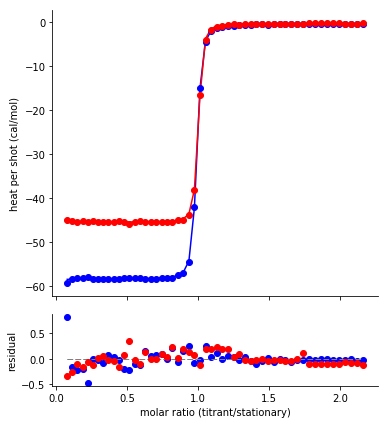

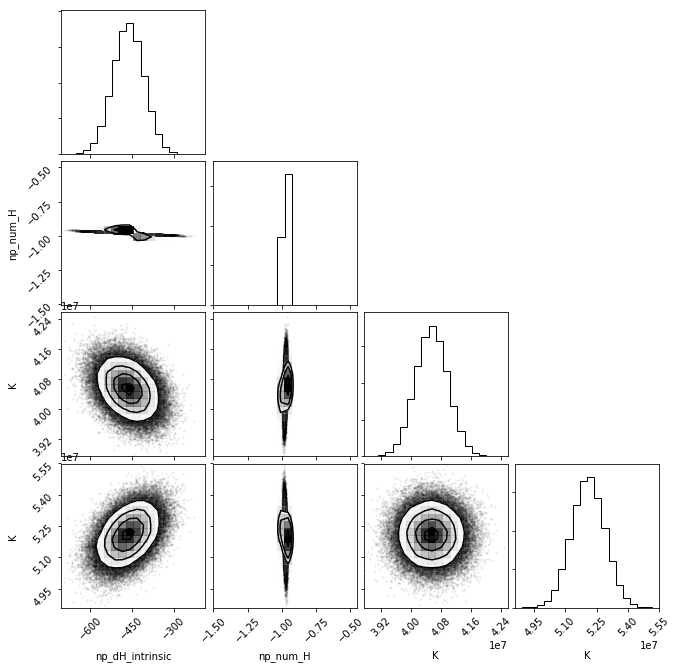

In [3]:
# --------------------------------------------------------------------
# define buffer ionization enthalpies.
# goldberg et al (2002) Journal of Physical and Chemical Reference Data 31 231,  doi: 10.1063/1.1416902
TRIS_IONIZATION_DH = 47.45/4.184*1000 # cal/mol
IMID_IONIZATION_DH = 36.64/4.184*1000 # cal/mol

class MyNumProtons(pytc.GlobalConnector):
    param_guesses = {"num_H":0.1,"dH_intrinsic":0.0}
    required_data = ["ionization_enthalpy"]
    
    def dH(self,experiment):

        return self.dH_intrinsic + self.num_H*experiment.ionization_enthalpy


# --------------------------------------------------------------------
# Create a global fitting instance
g = pytc.GlobalFit()
num_protons = MyNumProtons("np")

# ------------------------------------------------------------------------------------
# Tris buffer experiment

tris = pytc.ITCExperiment("ca-edta/tris-01.DH",pytc.indiv_models.SingleSite,shot_start=2)
tris.ionization_enthalpy = TRIS_IONIZATION_DH

g.add_experiment(tris)
g.link_to_global(tris,"dH",num_protons.dH)

# ------------------------------------------------------------------------------------
# Imidazole buffer experiment

imid = pytc.ITCExperiment("ca-edta/imid-01.DH",pytc.indiv_models.SingleSite,shot_start=2)
imid.ionization_enthalpy = IMID_IONIZATION_DH

g.add_experiment(imid)
g.link_to_global(imid,"dH",num_protons.dH)

# --------------------------------------------------------------------
# Do a global fit
g.fit()

# Show the results
fig, ax = g.plot()
c = g.corner_plot()
print(g.fit_as_csv)